## Proyección de variables
### Análisis de Componentes Principales (PCA)

In [1]:
import numpy as np
from scipy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

faces,_ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=0)
print(faces.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\pablo.nahuel.pelli\scikit_learn_data
(400, 4096)


Grafico una imagen para tener de referencia

<Figure size 640x480 with 0 Axes>

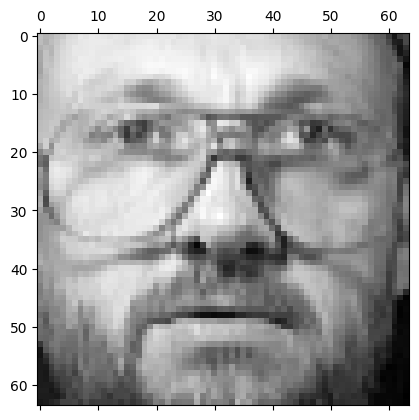

In [2]:
import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(faces[0].reshape((64,64)))
plt.show() 

In [3]:
pca_faces = PCA()
pca_faces.fit(faces)
print(pca_faces.components_.shape)

(400, 4096)


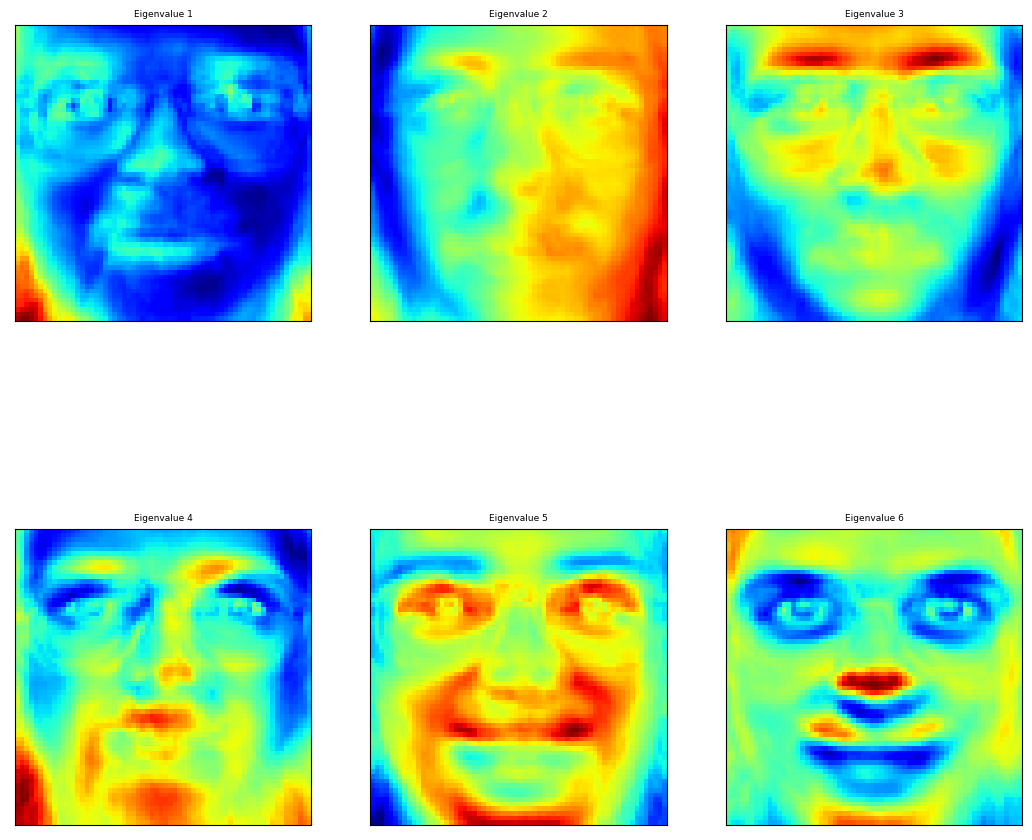

In [4]:
n_row = 2
n_col = 3

# Plot the first 8 eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(pca_faces.components_[i].reshape(64,64), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())

#### Criterios de selección del orden.

Una pregunta importante es cómo elijo la cantidad $m$ de features a retener. Existen dos enfoques comúnmente usados:
- Busco explicar el k% de la varianza de los datos: $m$  es tal que $\frac{\sum_{i=1}^m \sigma_i}{\sum_{i=1}^p \sigma_i}100 > k$
- Método del codo ('elbow'). Grafico los $\sigma_i$ y tomo $m$  en el punto de inflexión de la curva.

Esto se puede ver con el atributo $\texttt{explained\_variance\_ratio\_}$

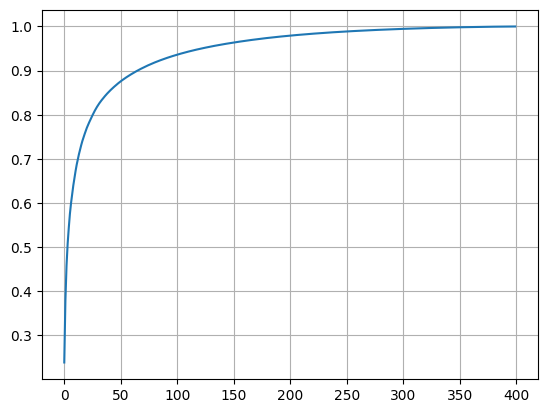

In [5]:
plt.plot(np.cumsum(pca_faces.explained_variance_ratio_)); plt.grid(True);

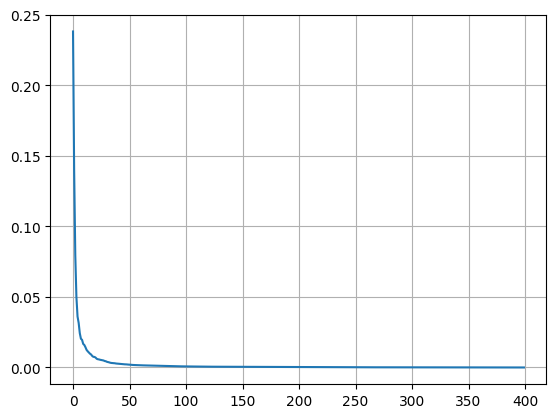

In [6]:
plt.plot(pca_faces.explained_variance_ratio_); plt.grid(True);

#### Conclusiones

- **Ventajas**:
    - Obtengo features descorrelacionados
    - No "tiro" información de ninguna variable
    - Explicable en términos de la matriz de correlación
    - No supervisado (sirve para mayor cantidad de problemas)
    
- **Desventajas**:
    - Si el dataset es muy grande puede ser muy costoso de computar
    - Pierdo explicabilidad de los features (ahora son una c.l. de las mediciones)

- **Observaciones**:
    Las direcciones de los componentes principales se pueden ver afectadas por las unidades de medida, por ejemplo un feature es la altura en metros de una persona y otra el peso en gramos). Una práctica común estandarizar las variables para que tengan media 0 y varianza 1 antes de aplicar PCA.

## Independent Component Analysis (ICA)

A diferencia de PCA, el objetivo de ICA es hallar una transformación de mis variables originales de forma tal que los componentes resulten independientes entre sí. 
Vamos a usar el mismo dataset de MNIST para comparar con los resultados obtenidos por PCA

In [24]:
ica_faces = ICA(n_components=6, max_iter=1000)
ica_faces.fit(faces)
print(ica_faces.components_.shape)

c:\Users\pablo.nahuel.pelli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


(6, 4096)


In [25]:
ica_faces.n_iter_

327

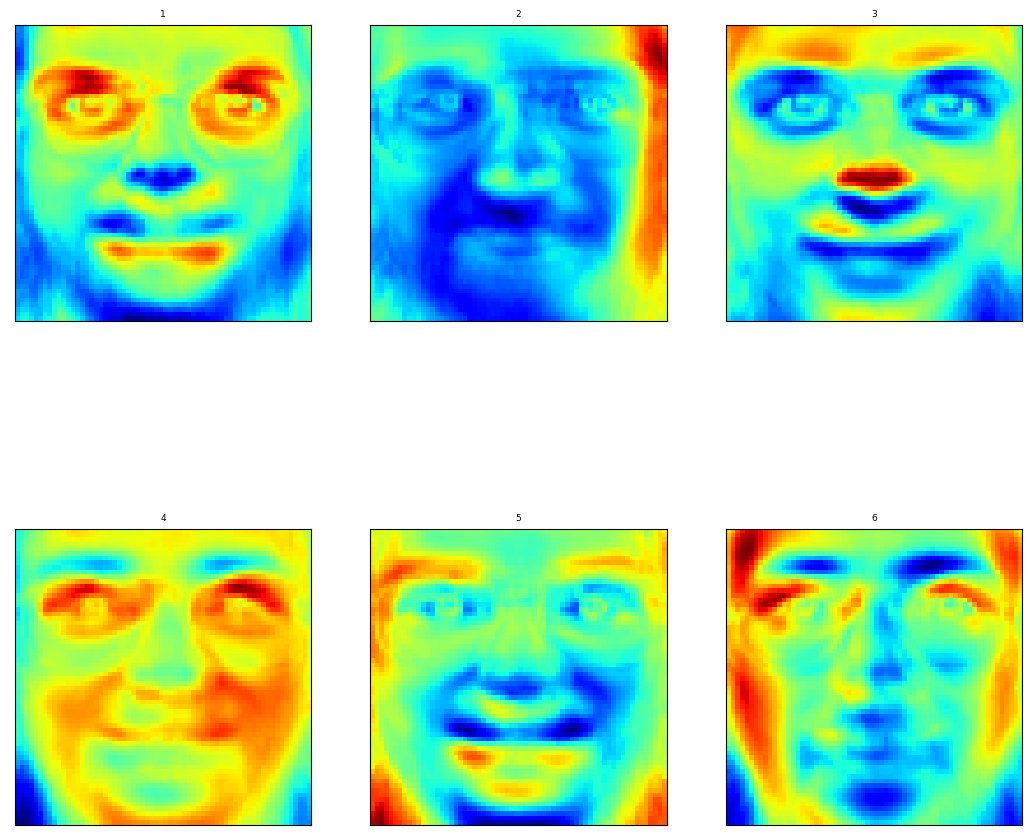

In [26]:
n_row = 2
n_col = 3

# Plot the first 8 eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(ica_faces.components_[i].reshape(64,64), cmap='jet')
    title_text = str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())

## Descomposición en Valores Singulares (SVD)

La descomposición en valores singulares es muy popular para reducir dimensiones para datos *sparse* (datos donde gran cantidad de los features tiene valor nulo para cada medición). 

Recordemos un poco la SVD. Tenemos $\mathbf{X} \in \mathbb{R}^{n\times p}$ una matriz de $n$ observaciones de $p$ variables. Luego, $\mathbf{X}$ se puede descomponer como 

$$\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T,$$

donde $\mathbf{U}\in\mathbb{R}^{n\times n}$, $\mathbf{V}\in\mathbb{R}^{p\times p}$ y $\mathbf{\Sigma} \in \mathbb{R}^{n\times p}$ es una matriz "diagonal"
     
![SVDdiagram.png](SVDdiagram.png)

Análogamente a lo que se hizo para PCA, para reducir las dimensiones podemos proyectar los datos sobre las primeras $k$ columnas de $\mathbf{V}$
$$\hat{\mathbf{X}} = \mathbf{X}\mathbf{V_k},$$
donde $\mathbf{V}_k = [\mathbf{v}_1, \ldots, \mathbf{v}_k]$

#### Implementación paso a paso
 

$\mathbf{X}$ es una matriz de $n$ filas por $p$ columnas donde cada columna representa una feature o característica y cada fila una muestra.

$$
\mathbf{X} =
\begin{bmatrix}
x_{11} & x_{12} &  ... & x_{1p} \\
x_{21} & x_{22} &  ... & x_{2p} \\
... & ... &  ... & ... \\
x_{n1} & x_{n2} &  ... & x_{np} \\
\end{bmatrix}
$$

In [9]:
X = np.array([
  [1,2,3,4,5,6,7,8,9,10],
  [11,12,13,14,15,16,17,18,19,20],
  [21,22,23,24,25,26,27,28,29,30]
])
X

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]])

1) Calculo la descomposición en valores singulares (SVD) de la matriz de datos $\mathbf{X}$, obteniendo $\mathbf{U}$, $\mathbf{\Sigma}$, $\mathbf{V}$

In [10]:
U, s, Vt = svd(X)

2) Observo los valores singulares, s para elegir la cantidad de dimensiones a elegir

In [11]:
s

array([9.69657342e+01, 7.25578339e+00, 5.43064394e-15])

3) Retengo las $k$ dimensiones más relevantes, y reduzco las diemensiones de las matrices para hallar $\mathbf{U}_k$, $\mathbf{\Sigma}_k$, $\mathbf{V}_k$

In [27]:
k = 2
s= s[:k]
Vt = Vt[:k,:]
U = U[:,:k]

4) Puedo observar la versión "recuperada" de $\mathbf{X}$, y hallo los datos transformados $\mathbf{T} = \mathbf{X}\mathbf{V}_k$ 

In [13]:
X_red = U.dot(np.diag(s).dot(Vt))
X_red

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [11., 12., 13., 14., 15., 16., 17., 18., 19., 20.],
       [21., 22., 23., 24., 25., 26., 27., 28., 29., 30.]])

In [14]:
T = X.dot(Vt.T) # seria como el PCA pero sobre los datos sin centrar.
T

array([[-18.52157747,   6.47697214],
       [-49.81310011,   1.91182038],
       [-81.10462276,  -2.65333138]])

Nuevamente, podemos implementar una clase con nuestra versión de SVD

In [15]:
class mySVD:
    def __init__(self, n_components = None):
        self.U = None
        self.s = None
        self.V = None
        self.n_components = n_components
        pass
    def fit(self, X):
        n,p = X.shape
        self.U, self.s, self.V = svd(X)
        self.U = self.U[:,:min(n,p)]
        self.V = self.V[:min(n,p)].T
        if self.n_components:
            self.U = self.U[:,:self.n_components]
            self.V = self.V[:,:self.n_components]
            self.s = self.s[:self.n_components]
        pass
            
    def transform(self, X):
        return X.dot(self.V)
        

#### Comparación de resultado con scikit-learn

In [16]:
from sklearn.decomposition import TruncatedSVD
my_svd = mySVD(2)
my_svd.fit(X)
sk_svd = TruncatedSVD(2).fit(X)


In [17]:
my_svd.transform(X)

array([[-18.52157747,   6.47697214],
       [-49.81310011,   1.91182038],
       [-81.10462276,  -2.65333138]])

In [18]:
sk_svd.transform(X)

array([[18.52157747,  6.47697214],
       [49.81310011,  1.91182038],
       [81.10462276, -2.65333138]])

In [19]:
assert(
    np.any(
        [np.all(
            np.isclose(
                sk_svd.transform(X), 
                my_svd.transform(X)
            )
        ),
        np.all(
            np.isclose(
                -sk_svd.transform(X), 
                my_svd.transform(X)
            )
        )]
    )
)
# agego comparación con el negado porque SVD tiene el problema de "sign indeterminacy"

AssertionError: 

### ¿Qué representan las matrices $\mathbf{U}$ y $\mathbf{V}$? 

$\mathbf{U}$ se corresponde  con los autovectores de $\mathbf{X}\mathbf{X}^T$, mientras $\mathbf{V}$ está asociada a los avutovectores de $\mathbf{X}^T\mathbf{X}$ y $\mathbf{\Sigma}$ se corresponde con la raíz cuadrada de lo autovalores de ambas matrices. Lo interesante, es que $\mathbf{X}^T\mathbf{X}$ es la correlación empírica de los features, mientras que $\mathbf{X}\mathbf{X}^T$ es la correlación empírica entre muestras. 

#### Pongamos un ejemplo
La siguiente matriz representa la puntuación de distintos usuarios a 5 películas <sup>[1]</sup>.

![matriz_pelis.png](matriz_pelis.png)

En este caso, la descomposición en valores singulares resulta

$$\begin{array}{c c c c c}
\left[\begin{smallmatrix} 1& 1&1&0&0\\ 3&3&3&0&0\\ 4&4&4&0&0 \\ 5&5&5&0&0 \\ 0&0&0&4&4\\0&0&0&5&5\\0&0&0&2&2 \end{smallmatrix}\right] & = & \left[\begin{smallmatrix} 0.14 & 0\\ 0.42&0\\0.56&0\\0.7&0\\0&0.6\\0&0.75\\0&0.3\end{smallmatrix}\right] & \left[\begin{smallmatrix}12.4&0\\0&9.5 \end{smallmatrix}\right] & \left[\begin{smallmatrix} 0.58 &0.58 & 0.58 &0&0\\0&0&0&0.71&0.71\end{smallmatrix}\right]\\
\mathbf{X} & & \mathbf{U} & \mathbf{\Sigma} & \mathbf{V}^T
\end{array}$$

¿Qué observamos?
La matriz $\mathbf{U}$ conecta personas a tópicos ("ciencia ficción", y "románticas"), mientras que $\mathbf{V}$ conecta películas a tópicos. De esta forma, nos separa las distintas películas en categorías, y separa a los usuarios según categorías de películas. La matriz $\mathbf{\Sigma}$ nos devuelve la intensidad de cada conceptos. En este caso, como más usuarios ratearon películas de ciencia ficción, esta categoría tiene  mayor peso.

En general, las categorías van a estar cruzadas, por ejemplo alguien que ve mayormente películas románticas puede haber visto Matrix. En este caso vamos a tener mayor cantidad de valores singulares positivos. Lo que se hace es descartar aquellos valores singulares significativamente más pequeños que el resto.


### Comentarios:
- Realizar la descomposición SVD sobre los datos centrados es equivalente a hacer PCA
- SVD funciona sobre datos sparse, sin necesidad de "redensificarlos" que puede ocupar mucha memoria
- Por cómo se implementa el algoritmo, puede ocurrir que entre distintos entrenamientos (fitteos) se intercambie el signo de los vectores. Una forma de mitigar este inconveniente es entrenando una única vez y luego transformando varias veces. 
- Según el problema, las matrices $\mathbf{U}$ y $\mathbf{V}$ de SVD pueden dar información útil acerca de las correlaciones entre las muestras y las entre las variables.

## Bibliografia:

[1] "Mining of Massive Datasets",  Leskovec J, Rajaraman A., Ullman J.D., Stanford University. Capítulo 11. http://infolab.stanford.edu/~ullman/mmds/ch11.pdf

[2] https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

[3] "Pattern Recognition and Machine Learning", Bishop, Christopher M. New York, Springer, 2006

